In [24]:
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
from PIL import Image
import io
import numpy as np
import matplotlib.pyplot as plt

In [25]:
CLIENT_ID = "e13ab71f-3721-47af-a92c-d7fdafd34165"
CLIENT_SECRET = "Z@l4jf(pEH8;KG_?O{O+C<<ks3]^P38okuP}mUB3"

# set up credentials
client = BackendApplicationClient(client_id=CLIENT_ID)
oauth = OAuth2Session(client=client)

# get an authentication token
token = oauth.fetch_token(token_url='https://services.sentinel-hub.com/oauth/token',
                          client_id=CLIENT_ID, client_secret=CLIENT_SECRET)

In [64]:
# bbox = [390633.10289572447,5224916.541597763,391199.0981750366,5226182.439556519]
# bbox = [-87.72171, 17.11848, -87.342682, 17.481674]
bbox = [39.522849683378905,52.20080586254517,39.625646416472166,52.30116855678955]
# bbox = [ 37.520797,47.126142, 37.550797, 47.156142]
start_date = "2020-06-01"
end_date = "2020-08-31"
collection_id = "sentinel-2-l2a"

In [65]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["B02", "B03", "B04"],
    output: { 
      bands: 3, 
      sampleType: "AUTO" // default value - scales the output values from [0,1] to [0,255].
    }
  }
}

function evaluatePixel(sample) {
  return [2.5 * sample.B04, 2.5 * sample.B03, 2.5 * sample.B02]
}
"""

# request body/payload
json_request = {
    'input': {
        'bounds': {
            'bbox': bbox,
            'properties': {
                'crs': 'http://www.opengis.net/def/crs/OGC/1.3/CRS84'
            }
        },
        'data': [
            {
                'type': 'S2L2A',
                'dataFilter': {
                    'timeRange': {
                        'from': f'{start_date}T00:00:00Z',
                        'to': f'{end_date}T23:59:59Z'
                    },
                    'mosaickingOrder': 'leastCC',
                },
            }
        ]
    },
    'output': {
        'width': 1024,
        'height': 1024,
        'responses': [
            {
                'identifier': 'default',
                'format': {
                    'type': 'image/jpeg',
                }
            }
        ]
    },
    'evalscript': evalscript
}

In [66]:
# Set the request url and headers
url_request = 'https://services.sentinel-hub.com/api/v1/process'
headers_request = {
    "Authorization" : "Bearer %s" %token['access_token']
}

#Send the request
response = oauth.request(
    "POST", url_request, headers=headers_request, json = json_request
)

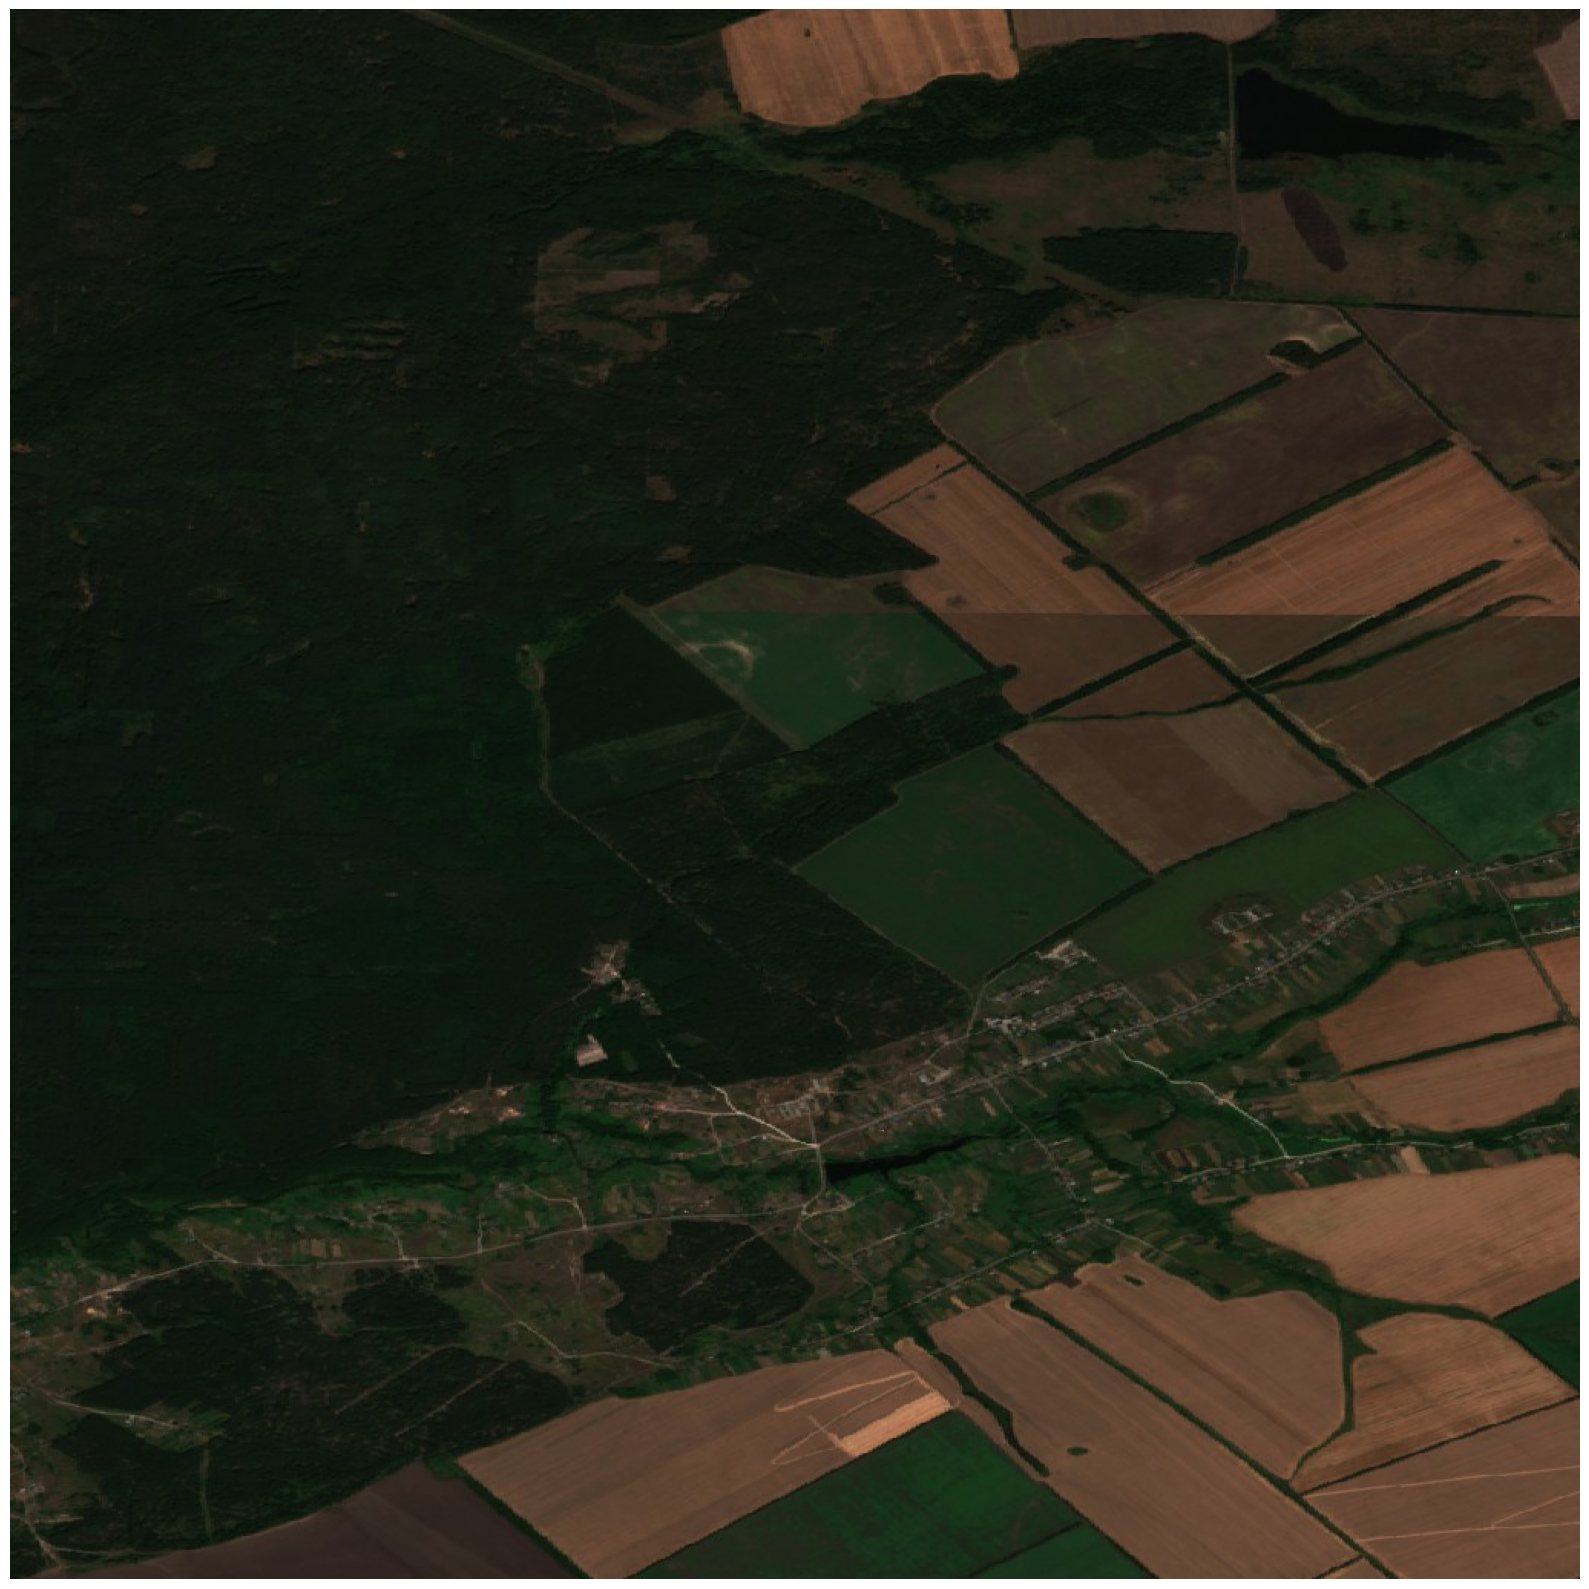

In [67]:
# read the image as numpy array
image_arr = np.array(Image.open(io.BytesIO(response.content)))

# plot the image for visualization
plt.figure(figsize=(16,16))
plt.axis('off')
plt.tight_layout()
plt.imshow(image_arr)

In [57]:
json_search = {
    'bbox': bbox,
    'datetime': f'{start_date}T00:00:00Z/{end_date}T23:59:59Z',
    'collections': [collection_id],
    'limit': 1
}

In [58]:
# set the url and headers
url_search = 'https://services.sentinel-hub.com/api/v1/catalog/search'
headers_search = {
  'Content-Type': 'application/json'
}

# send the request
response_search = oauth.request(
    "POST", url_search, headers=headers_search, json = json_search
)

In [59]:
response_search.json()

{'type': 'FeatureCollection',
 'features': [{'stac_version': '0.9.0',
   'stac_extensions': ['eo', 'projection'],
   'id': 'S2B_MSIL2A_20200831T082609_N0214_R021_T37TCN_20200831T111344',
   'type': 'Feature',
   'geometry': {'type': 'MultiPolygon',
    'crs': {'type': 'name',
     'properties': {'name': 'urn:ogc:def:crs:OGC::CRS84'}},
    'coordinates': [[[[36.32794056436905, 47.82258644892732],
       [36.37729302234726, 46.83565300257248],
       [37.8166351529031, 46.859591943819815],
       [37.79434183412165, 47.84736201505866],
       [36.32794056436905, 47.82258644892732]]]]},
   'bbox': [36.32794056436905,
    46.83565300257248,
    37.8166351529031,
    47.84736201505866],
   'properties': {'datetime': '2020-08-31T08:37:03Z',
    'platform': 'sentinel-2b',
    'instruments': ['msi'],
    'constellation': 'sentinel-2',
    'eo:gsd': 10,
    'eo:cloud_cover': 0.0,
    'eo:bands': [{'name': 'B01',
      'common_name': 'coastal',
      'center_wavelength': 0.4427,
      'full_widt